#### Fine Tuning a Custom Model

In [ ]:
!pip install -U -q "google-generativeai>=0.7.2"

In [ ]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
newsgroups_train.target_names

In [ ]:
''' Prepare the Dataset '''
import email, re, pandas as pd

def preprocess_newsgroup_row(data):
  msg = email.message_from_string(data)
  text = f" {msg['Subject']}\n\n{msg.get_payload()} "
  text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
  text = text[:40000]
  return text

def preprocess_newsgroup_data(newsgroup_dataset):
  df = pd.DataFrame(
    {'Text': newsgroup_dataset.data, 'Label': newsgroup_dataset.target} )
  df['Text'] = df['Text'].apply(preprocess_newsgroup_row)
  df['Class Name'] = df['Label'].map(lambda l: newsgroup_dataset.target_names[l])
  return df

df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)
df_train.head()

In [ ]:
''' Sample Data '''
def sample_data(df, num_samples, classes_to_keep):
  df = (
      # sample rows, selecting num_samples of each label
      df.groupby('Label')[df.columns].apply(
          lambda x: x.sample(num_samples)).reset_index(drop=True)
  )
  df = df[df['Class Name'].str.contains(classes_to_keep)]
  df['Class Name'] = df['Class Name'].astype('category')
  return df

train_num_samples = 50
test_num_samples = 10
classes_to_keep = '^rec|^sci'
df_train = sample_data(df_train, train_num_samples, classes_to_keep)
df_test = sample_data(df_test, test_num_samples, classes_to_keep)

In [ ]:
''' Identify a sample row to use for visual inspection '''
sample_idx = 0
sample_row = preprocess_newsgroup_row(newsgroups_test.data[sample_idx])
sample_label = newsgroups_test.target_names[newsgroups_test.target[sample_idx]]
print(sample_row)
print('_________________')
print('Label:', sample_label)

In [ ]:
''' Evaluate Baseline performance '''
baseline_model = genai.GenerativeModel('gemini-1.5-flash-002')
response = baseline_model.generate_content(sample_row)
print(response.text)

In [ ]:
prompt = 'from what newsgroup doesthe following message originates from'
baseline_response = baseline_model.generate_content([prompt, sample_row])
Markdown(baseline_response.text)

In [ ]:
''' system instruction to do more direct prompting '''
from google.api_core import retry
system_instruct = '''
this is a classification service
this will pass input that represents a newsgroup post and it responds with a
newsgroup post from where it originates from
'''
instructed_model = genai.GenerativeModel('gemini-1.5-flash-002',
                system_instruction=system_instruct)
retry_policy = {'retry': retry.Retry(predicate=retry.if_transient_error)}

def predict_label(post: str)->str:
  response = instructed_model.generate_content(post, request_options=retry_policy)
  resp = response.candidates[0]
  if resp.finish_reason.name != 'STOP':
    return '{error}'
  else:
    return response.text.strip()

In [ ]:
prediction = predict_label(sample_row)
prediction, 'Correct' if prediction == sample_label else 'Incorrect'

('rec.autos', 'Correct')

In [ ]:
from tqdm.rich import tqdm
tqdm.pandas()
df_baseline_eval = sample_data(df_test, 2, '.*') # sample data
df_baseline_eval['Prediction'] = \
  df_baseline_eval['Text'].progress_apply(predict_label) # make predictions
accuracy = (df_baseline_eval['Class Name'] == \
            df_baseline_eval['Prediction']).sum() / len(df_baseline_eval)
print(f'Accuracy: {accuracy: 2%}')

Output()

/usr/local/lib/python3.11/dist-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


Accuracy:  37.500000%


## Tune a custom Model

In [ ]:
import random
from collections.abc import Iterable

In [ ]:
model_id = f'newsgroup-classifier-{random.randint(10000, 99999)}'
# upload training data and queue the tuning job
tuning_op = genai.create_tuned_model(
    'models/gemini-1.5-flash-001-tuning',
    training_data = df_train,
    input_key = 'Text',
    output_key = 'Class Name',
    id = model_id,
    display_name = 'Newsgroup classification model',
    batch_size = 16,
    epoch_count = 2,
)

 Done! The model is ACTIVE


<Axes: xlabel='step', ylabel='mean_loss'>

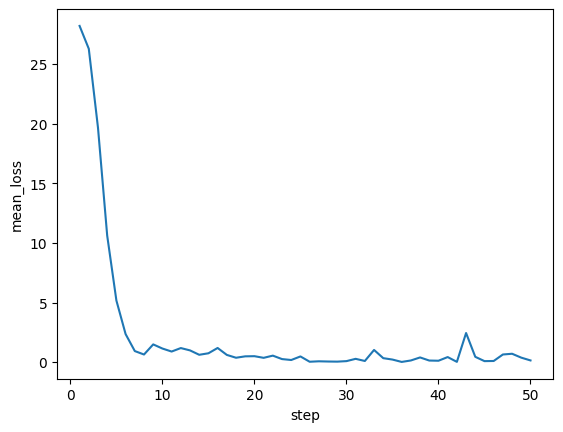

In [ ]:
import time, seaborn as sns
while (tuned_model := genai.get_tuned_model(
    f'tunedModels/{model_id}')).state.name != 'ACTIVE':
    print(tuned_model.state)
    time.sleep(60)
print(f' Done! The model is {tuned_model.state.name}')

snapshots = pd.DataFrame(tuned_model.tuning_task.snapshots)
sns.lineplot(data=snapshots, x='step', y='mean_loss')

### Use the new Model

In [ ]:
your_model = genai.GenerativeModel(f'tunedModels/{model_id}')
new_text = ''' goes here '''
response = your_model.generate_content(new_text)
print(response.text)

In [ ]:
your_model

genai.GenerativeModel(
    model_name='tunedModels/newsgroup-classifier-84556',
    generation_config={},
    safety_settings={},
    tools=None,
    system_instruction=None,
    cached_content=None
)

### Evaluation

In [ ]:
def classify_text(text: str) -> str:
  response = your_model.generate_content(text, request_options=retry_policy)
  resp = response.candidates[0]
  if resp.finish_reason.name != 'STOP':
    return '(error)'
  else:
    return resp.content.parts[0].text

df_model_eval = sample_data(df_test, 4, '.*')
df_model_eval['Prediction'] = df_model_eval['Text'].progress_apply(classify_text)
accuracy = (
  df_model_eval['Class Name'] == df_model_eval['Prediction']).sum() /len(df_model_eval)
print(f'Accuracy: {accuracy: 2%}')

Output()

/usr/local/lib/python3.11/dist-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


Accuracy:  93.750000%


### Compute Token usage

In [ ]:
''' Calculate the input cost of the baselibe model with system instructions '''
tokens = instructed_model.count_tokens(sample_row).total_tokens
f'System baseline model {tokens} (input)'

'System baseline model 172 (input)'

In [ ]:
baseline_token_output = baseline_response.usage_metadata.candidates_token_count
f'Baseline output tokens {baseline_token_output}'

'Baseline output tokens 63'

In [ ]:
f'Tuned output tokens \
{your_model.generate_content(sample_row).usage_metadata.candidates_token_count}'

'Tuned output tokens 3'

In [ ]:
your_model.generate_content(sample_row)

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "rec.autos"
              }
            ],
            "role": "model"
          },
          "finish_reason": "STOP",
          "index": 0,
          "safety_ratings": [
            {
              "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_HATE_SPEECH",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_HARASSMENT",
              "probability": "NEGLIGIBLE"
            },
            {
              "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
              "probability": "NEGLIGIBLE"
            }
          ]
        }
      ],
      "usage_metadata": {
        "prompt_token_count